## Identifying Volcanoes in Venus Images with ML Models

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform, randint


#### Reading the datasets

In [2]:
feat_train = pd.read_csv('train_images.csv', header = None)
resp_train = pd.read_csv('train_labels.csv')

feat_test = pd.read_csv('test_images.csv', header = None)
resp_test = pd.read_csv('test_labels.csv')

#### Checking the values of pixels of a random picture

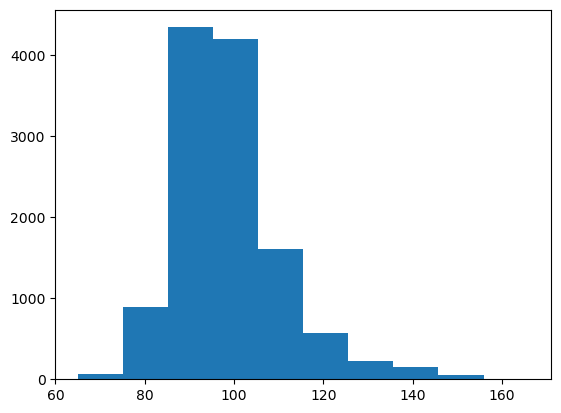

2784


In [3]:
r = np.random.randint(1, 7000)
plt.hist(feat_train.values[r])
plt.show()
print(r)

#### Checking the behavior of column 350

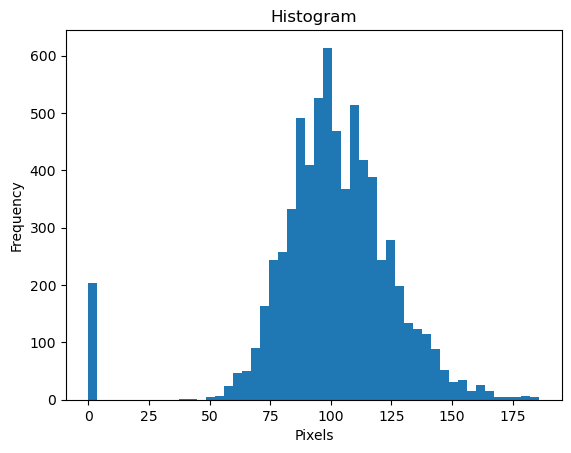

In [4]:
pixel_350 = feat_train.iloc[:, 350].tolist()

plt.hist(pixel_350, bins=50)
plt.title('Histogram')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.show()



#

#### The goal is to concentrate solely on the central region of the picture, given that the volcano is typically located there. Therefore, I'll transform the 110x110 image into a 10x10.

In [5]:
def center_10x10(image):
    image_reshaped = image.values.reshape(110, 110)

    height, width = image_reshaped.shape

    start_x, start_y = int((width - 10) / 2), int((height - 10) / 2)

    end_x, end_y = start_x + 10, start_y + 10

    center_10x10 = image_reshaped[start_y:end_y, start_x:end_x]

    return center_10x10.flatten()

#### Resizing

In [6]:
x_train = feat_train.apply(center_10x10, axis=1)
x_train = pd.DataFrame(list(x_train))

x_test = feat_test.apply(center_10x10, axis=1)
x_test = pd.DataFrame(list(x_test))

y_train = resp_train["Volcano?"]
y_test = resp_test["Volcano?"]

x_test.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,104,105,91,90,113,116,108,100,103,97,...,101,110,111,106,105,103,96,99,99,97
1,108,135,134,116,100,105,99,93,95,92,...,87,95,103,106,121,126,111,98,98,104
2,135,140,122,117,126,125,113,116,111,109,...,142,135,142,137,115,102,110,121,126,116
3,102,116,117,95,93,92,91,88,93,89,...,84,91,80,80,93,82,81,97,98,88
4,92,120,119,105,98,116,97,97,97,91,...,97,104,102,98,103,97,94,92,91,62


#### Transforming the values to be within the range of 0 and 1.

In [7]:
x_train = x_train/x_train.max().max()
x_test = x_test/x_test.max().max()

In [8]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(12, 10))
    index = 1
    for x in zip(images, title_texts):
        image = x[0].reshape(110, 110)
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

def show_images10x10(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(12, 10))
    index = 1
    for x in zip(images, title_texts):
        image = x[0].reshape(10, 10)
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

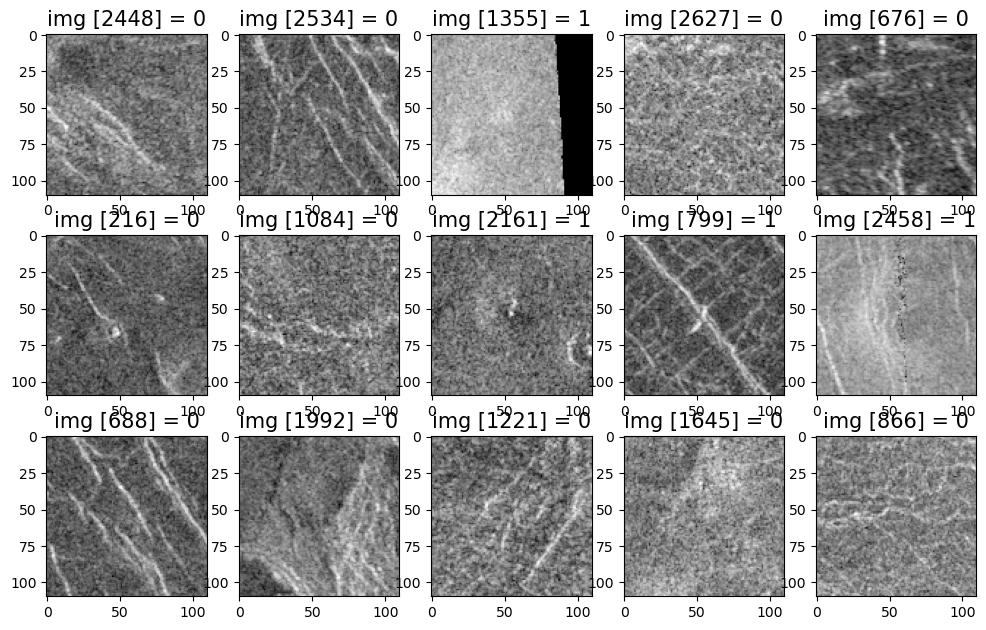

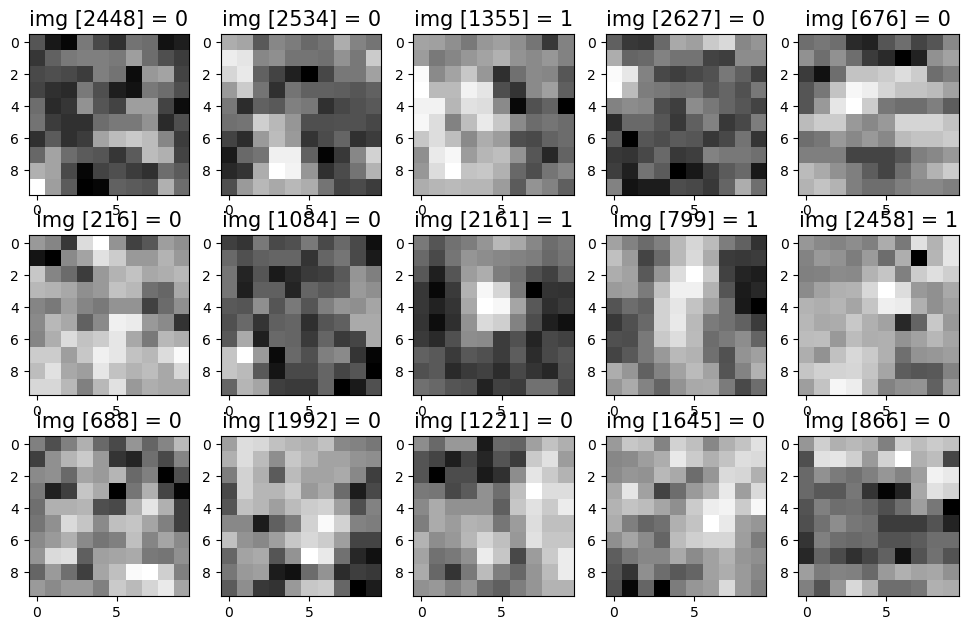

In [9]:
random_images_110 = []
random_images_10 = []
for i in range(0, 15):
    r = np.random.randint(1, 2734)
    random_images_110.append((feat_test.values[r], 'img [' + str(r) + '] = ' + str(resp_test["Volcano?"][r])))
    random_images_10.append((x_test.values[r], 'img [' + str(r) + '] = ' + str(resp_test["Volcano?"][r])))

show_images(list(map(lambda x: x[0], random_images_110)), list(map(lambda x: x[1], random_images_110)))
show_images10x10(list(map(lambda x: x[0], random_images_10)), list(map(lambda x: x[1], random_images_10)))

### Defining some functions that will be used

In [10]:
def matprint(mat, fmt="g", round_dig = 0):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            if round_dig == 0:
                print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
            else:
                print(("{:"+str(col_maxes[i])+fmt+"}").format(round(y, round_dig)), end="  ")
        print("")

In [11]:
def accuracy(clf, X_test, y_test ):
    CM = confusion_matrix(y_test, clf.predict(X_test))

    Pop = np.size(y_test)
    VN = CM[0, 0]
    VP = CM[1, 1]
    Acc = (VN + VP)/Pop

    return Acc

In [12]:
def falsePos (clf, X_test, y_test ):
    CM = confusion_matrix(y_test, clf.predict(X_test))

    N = np.size(np.where(y_test == 0))

    FP = CM[0, 1]

    FPR = FP/N

    return FPR

In [13]:
def falseNeg (clf, X_test, y_test ):
    CM = confusion_matrix(y_test, clf.predict(X_test))

    P = np.size(np.where(y_test == 1))

    FN = CM[1, 0]

    FNR = FN/P

    return FNR

In [14]:
def metrics(clf, X_test, y_test, score_f1 = False ,  gridsearch = False):

    CM = confusion_matrix(y_test, clf.predict(X_test))

    Pop = np.size(y_test)
    N = np.size(np.where(y_test == 0))
    P = np.size(np.where(y_test == 1))

    VN = CM[0, 0]
    FP = CM[0, 1]
    FN = CM[1, 0]
    VP = CM[1, 1]

    Prev = P/Pop
    Acc = (VN + VP)/Pop

    FPR = FP/N
    TNR = VN/N
    TPR = VP/P
    FNR = FN/P

    FOR = FN/(VN + FN)
    PPV = VP/(FP + VP)
    NPV = VN/(VN + FN)
    FDR = FP/(FP + VP)

    F1 = 2/(1/PPV + 1/TPR)

    if score_f1 == True:
        return F1
    else:
        print('\nConfusion Matrix:')
        matprint(CM)

        print("\n     Metrics: ")

        print('Prevalence:', Prev)
        print('Accuracy:', Acc)


        print('\nFalse Positive Rate:', FPR)
        print('True Negative Rate (Specificity):', TNR)
        print('True Positive Rate (Recall):', TPR)
        print('False Negative Rate:', FNR)

        print('\nFalse omission rate:', FOR)
        print('Positive Predictive Value (Precision):', PPV)
        print('Negative Predictive Value:', NPV)
        print('False discovery rate:', FDR)

        print('\nF1 Score:', F1)

In [15]:
def function_svc(svc, X_train, y_train, X_test, y_test, gridsearch = False):
    if gridsearch:
        print('Number of support vectors: ', svc.best_estimator_.support_.size)
    else:
        print('Number of support vectors: ', svc.support_.size)

    CM = confusion_matrix(y_test, svc.predict(X_test))

    Pop = np.size(y_test)
    N = np.size(np.where(y_test == 0))
    P = np.size(np.where(y_test == 1))

    VN = CM[0, 0]
    FP = CM[0, 1]
    FN = CM[1, 0]
    VP = CM[1, 1]

    Prev = P/Pop
    Acc = (VN + VP)/Pop

    FPR = FP/N
    TNR = VN/N
    TPR = VP/P
    FNR = FN/P

    FOR = FN/(VN + FN)
    PPV = VP/(FP + VP)
    NPV = VN/(VN + FN)
    FDR = FP/(FP + VP)

    F1 = 2/(1/PPV + 1/TPR)

    print('\nConfusion Matrix:')
    matprint(CM)

    print("\n    Metrics: ")

    print('Prevalence:', Prev)
    print('Accuracy:', Acc)


    print('\nFalse Positive Rate:', FPR)
    print('True Negative Rate (Specificity):', TNR)
    print('True Positive Rate (Recall):', TPR)
    print('False Negative Rate:', FNR)

    print('\nFalse omission rate:', FOR)
    print('Positive Predictive Value (Precision):', PPV)
    print('Negative Predictive Value:', NPV)
    print('False discovery rate:', FDR)

    print('\nF1 Score:', F1)

In [16]:
def predictions (clf):

  predictions = clf.predict(x_test.values)

  correct_predictions = []
  wrong_predictions = []

  for i in range(len(predictions)):
    if predictions[i] == y_test.iloc[i]:
      correct_predictions.append(i)

    else:
      wrong_predictions.append(i)

  correct_predictions_qtt = len(correct_predictions)
  wrong_predictions_qtt = len(wrong_predictions)
  total_predictions_qtt = correct_predictions_qtt + wrong_predictions_qtt


  score_train = clf.score(x_train.values, y_train.values)
  score_test = clf.score(x_test.values, y_test.values)


  print("Correct predictions: {0}; Wrong predictions: {1}\n"
        .format(str(correct_predictions_qtt), str(wrong_predictions_qtt) ))

  print("Training Data Accuracy: {0}; Test Data Accuracy: {1}".format(score_train, score_test))
  print("Accuracy difference: {0:.4f}; Accuracy Inflation: {1:.4f}%"
        .format(score_train - score_test, 100 * (1 - (score_test/score_train))))

## Models

### Naive Bayes

In [17]:
gnb = GaussianNB()
gnb = gnb.fit(x_train, y_train)
predictions(gnb)

Correct predictions: 1452; Wrong predictions: 1282

Training Data Accuracy: 0.6021428571428571; Test Data Accuracy: 0.5310899780541332
Accuracy difference: 0.0711; Accuracy Inflation: 11.8000%


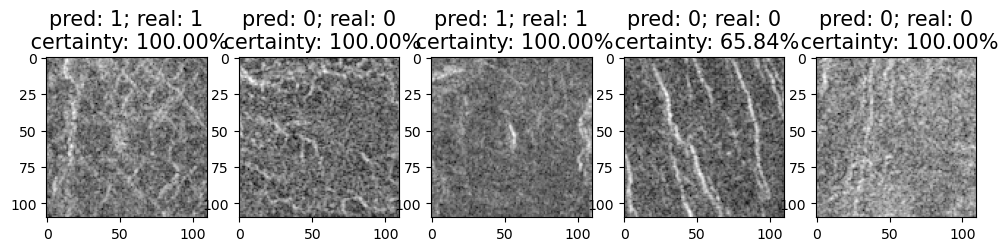

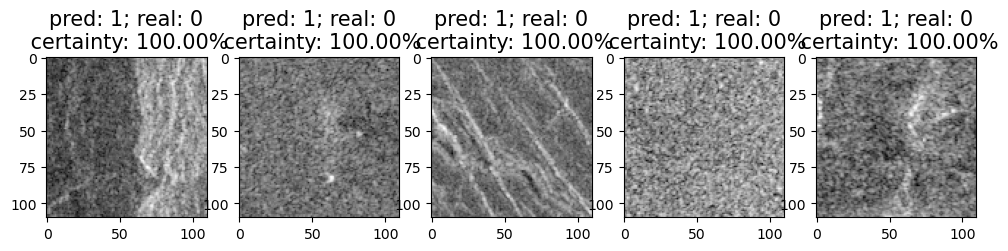

In [18]:
predictions_nb = gnb.predict(x_test)
predictions_prob_nb = gnb.predict_proba(x_test)

correct_predictions = []
wrong_predictions = []

for i in range(len(predictions_nb)):
  if predictions_nb[i] == y_test.iloc[i]:
    correct_predictions.append(i)

  else:
    wrong_predictions.append(i)

correct_indexes = []
for i in range(5):
  correct_indexes.append( correct_predictions[np.random.randint(0, len(correct_predictions))] )

wrong_indexes = []
for i in range(5):
  wrong_indexes.append( wrong_predictions[np.random.randint(0, len(wrong_predictions))] )

correct_imgs = []
pred_correct_imgs = []

wrong_imgs = []
pred_wrong_imgs = []

for index in correct_indexes:
  correct_imgs.append([feat_test.iloc[index]])
  pred_correct_imgs.append("pred: {0}; real: {1}\n certainty: {2:.2f}%".format(
    predictions_nb[index], resp_test["Volcano?"].iloc[index],
      100 * predictions_prob_nb[index][int(predictions_nb[index])]))

for index in wrong_indexes:
  wrong_imgs.append([feat_test.iloc[index]])
  pred_wrong_imgs.append("pred: {0}; real: {1}\n certainty: {2:.2f}%".format(
    predictions_nb[index], resp_test["Volcano?"].iloc[index],
      100 * predictions_prob_nb[index][int(predictions_nb[index])]))

show_images(np.array(correct_imgs),pred_correct_imgs)
show_images(np.array(wrong_imgs), pred_wrong_imgs)

In [19]:
metrics(gnb, x_test, y_test)


Confusion Matrix:
1088  1212  
  70   364  

     Metrics: 
Prevalence: 0.15874177029992684
Accuracy: 0.5310899780541332

False Positive Rate: 0.5269565217391304
True Negative Rate (Specificity): 0.47304347826086957
True Positive Rate (Recall): 0.8387096774193549
False Negative Rate: 0.16129032258064516

False omission rate: 0.06044905008635579
Positive Predictive Value (Precision): 0.23096446700507614
Negative Predictive Value: 0.9395509499136442
False discovery rate: 0.7690355329949239

F1 Score: 0.36218905472636814


## LDA

In [20]:
lda = LinearDiscriminantAnalysis()
lda = lda.fit(x_train, y_train)
predictions(lda)

Correct predictions: 2445; Wrong predictions: 289

Training Data Accuracy: 0.9101428571428571; Test Data Accuracy: 0.8942940746159473
Accuracy difference: 0.0158; Accuracy Inflation: 1.7414%


In [21]:
metrics(lda, x_test, y_test)


Confusion Matrix:
2249   51  
 238  196  

     Metrics: 
Prevalence: 0.15874177029992684
Accuracy: 0.8942940746159473

False Positive Rate: 0.02217391304347826
True Negative Rate (Specificity): 0.9778260869565217
True Positive Rate (Recall): 0.45161290322580644
False Negative Rate: 0.5483870967741935

False omission rate: 0.09569762766385204
Positive Predictive Value (Precision): 0.7935222672064778
Negative Predictive Value: 0.904302372336148
False discovery rate: 0.20647773279352227

F1 Score: 0.5756240822320118


## QDA

In [22]:
qda = QuadraticDiscriminantAnalysis()
qda = qda.fit(x_train, y_train)
predictions(qda)

Correct predictions: 2449; Wrong predictions: 285

Training Data Accuracy: 0.9487142857142857; Test Data Accuracy: 0.89575713240673
Accuracy difference: 0.0530; Accuracy Inflation: 5.5820%


In [23]:
metrics(qda, x_test, y_test)


Confusion Matrix:
2167  133  
 152  282  

     Metrics: 
Prevalence: 0.15874177029992684
Accuracy: 0.89575713240673

False Positive Rate: 0.05782608695652174
True Negative Rate (Specificity): 0.9421739130434783
True Positive Rate (Recall): 0.6497695852534562
False Negative Rate: 0.35023041474654376

False omission rate: 0.06554549374730487
Positive Predictive Value (Precision): 0.6795180722891566
Negative Predictive Value: 0.9344545062526951
False discovery rate: 0.3204819277108434

F1 Score: 0.6643109540636043


## KNN

In [24]:
KNN = KNeighborsClassifier()
param_grid_KNN = {"n_neighbors": range(1,70)}
KNNCV = GridSearchCV(KNN, param_grid = param_grid_KNN, scoring='accuracy', cv = 5, verbose = 3, n_jobs=-1)

In [25]:
KNNCV.fit(x_train.values, y_train.values)
print("\n Best n_neighbours by cross validation: ", KNNCV.best_params_['n_neighbors'])

Fitting 5 folds for each of 69 candidates, totalling 345 fits

 Best n_neighbours by cross validation:  5


In [26]:
predictions(KNNCV)

Correct predictions: 2499; Wrong predictions: 235

Training Data Accuracy: 0.9402857142857143; Test Data Accuracy: 0.9140453547915143
Accuracy difference: 0.0262; Accuracy Inflation: 2.7907%


In [27]:
metrics(KNNCV, x_test.values, y_test.values)


Confusion Matrix:
2263   37  
 198  236  

     Metrics: 
Prevalence: 0.15874177029992684
Accuracy: 0.9140453547915143

False Positive Rate: 0.01608695652173913
True Negative Rate (Specificity): 0.9839130434782609
True Positive Rate (Recall): 0.543778801843318
False Negative Rate: 0.45622119815668205

False omission rate: 0.08045509955302722
Positive Predictive Value (Precision): 0.8644688644688645
Negative Predictive Value: 0.9195449004469728
False discovery rate: 0.13553113553113552

F1 Score: 0.6676096181046677


### Decision Tree Classifier

In [28]:
DTC = DecisionTreeClassifier()
param_grid_DTC = {
    'max_depth': [None, 5, 10, 15], # Maximum tree depth
    'min_samples_split': [3, 5, 10], # Minimum number of samples required to split
    'min_samples_leaf': [1, 3, 5], # Minimum number of samples required at a leaf node
    'max_features': [None, 'sqrt', 'log2'], # Maximum number of features considered for splitting
    'criterion': ['gini', 'entropy'] # Split criterion
}

DTCV = GridSearchCV(DTC, param_grid=param_grid_DTC, scoring='accuracy', cv=5, verbose=3, n_jobs=-1)
DTCV.fit(x_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [3, 5, 10]},
             scoring='accuracy', verbose=3)

In [29]:
print("Best parameters: \n")

print("Criterion used to measure the quality of a split: ", DTCV.best_params_['criterion'])
print("Maximum tree depth: ", DTCV.best_params_['max_depth'])
print("Maximum number of features considered for splitting: ", DTCV.best_params_['max_features'])
print("Minimum samples at a leaf node: ", DTCV.best_params_['min_samples_leaf'])
print("Minimum number of samples required to split: ", DTCV.best_params_['min_samples_split'])

Best parameters: 

Criterion used to measure the quality of a split:  entropy
Maximum tree depth:  10
Maximum number of features considered for splitting:  None
Minimum samples at a leaf node:  1
Minimum number of samples required to split:  3


In [30]:
predictions(DTCV)

Correct predictions: 2396; Wrong predictions: 338

Training Data Accuracy: 0.9585714285714285; Test Data Accuracy: 0.8763716166788588
Accuracy difference: 0.0822; Accuracy Inflation: 8.5752%


In [31]:
metrics(DTCV, x_test, y_test)


Confusion Matrix:
2156  144  
 194  240  

     Metrics: 
Prevalence: 0.15874177029992684
Accuracy: 0.8763716166788588

False Positive Rate: 0.06260869565217392
True Negative Rate (Specificity): 0.9373913043478261
True Positive Rate (Recall): 0.5529953917050692
False Negative Rate: 0.4470046082949309

False omission rate: 0.0825531914893617
Positive Predictive Value (Precision): 0.625
Negative Predictive Value: 0.9174468085106383
False discovery rate: 0.375

F1 Score: 0.58679706601467


### Linear SVM

In [32]:
param_svm_linear  = [{'C' : [0.001, 0.01, 0.1, 1, 3, 5, 8, 10, 100, 1000]}]
svm_linear_cv = GridSearchCV(SVC(kernel = 'linear'), param_grid = param_svm_linear, cv = 5,
                             scoring = 'accuracy', verbose = 3, n_jobs = -1)

svm_linear_cv.fit(x_train, y_train)
print('Best estimator:', svm_linear_cv.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best estimator: SVC(C=3, kernel='linear')


In [33]:
predictions(svm_linear_cv)

Correct predictions: 2446; Wrong predictions: 288

Training Data Accuracy: 0.9104285714285715; Test Data Accuracy: 0.894659839063643
Accuracy difference: 0.0158; Accuracy Inflation: 1.7320%


In [34]:
function_svc(svm_linear_cv , x_train, y_train , x_test, y_test, gridsearch = True)

Number of support vectors:  1792

Confusion Matrix:
2275   25  
 263  171  

    Metrics: 
Prevalence: 0.15874177029992684
Accuracy: 0.894659839063643

False Positive Rate: 0.010869565217391304
True Negative Rate (Specificity): 0.9891304347826086
True Positive Rate (Recall): 0.39400921658986177
False Negative Rate: 0.6059907834101382

False omission rate: 0.10362490149724192
Positive Predictive Value (Precision): 0.8724489795918368
Negative Predictive Value: 0.8963750985027581
False discovery rate: 0.12755102040816327

F1 Score: 0.5428571428571428


### Polynomial SVM

In [35]:
param_poly = [{'C': [0.1, 1, 5, 10], 'gamma': [0.01, 0.1, 1],
               'coef0': [-1, 0, 1], 'degree': [2, 3, 4, 5]}]

svm_poly_CV = GridSearchCV(SVC(kernel = 'poly'), param_grid = param_poly, cv = 5,
                           scoring = 'accuracy', verbose = 3, n_jobs = -1)

svm_poly_CV.fit(x_train, y_train)

print('Best estimator:', svm_poly_CV.best_estimator_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best estimator: SVC(C=0.1, coef0=1, gamma=1, kernel='poly')


In [45]:
svm_poly_CV.best_params_['degree']

3

In [36]:
predictions(svm_poly_CV)

Correct predictions: 2546; Wrong predictions: 188

Training Data Accuracy: 0.9608571428571429; Test Data Accuracy: 0.9312362838332114
Accuracy difference: 0.0296; Accuracy Inflation: 3.0828%


In [37]:
function_svc(svm_poly_CV , x_train, y_train , x_test, y_test, gridsearch = True)

Number of support vectors:  1391

Confusion Matrix:
2254   46  
 142  292  

    Metrics: 
Prevalence: 0.15874177029992684
Accuracy: 0.9312362838332114

False Positive Rate: 0.02
True Negative Rate (Specificity): 0.98
True Positive Rate (Recall): 0.6728110599078341
False Negative Rate: 0.3271889400921659

False omission rate: 0.05926544240400668
Positive Predictive Value (Precision): 0.863905325443787
Negative Predictive Value: 0.9407345575959933
False discovery rate: 0.13609467455621302

F1 Score: 0.7564766839378237


### RBF SVM

In [38]:
param_rbf = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 20, 50, 100, 1000],
              'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100]}]

svm_rbf_CV = GridSearchCV(SVC(kernel = 'rbf'), param_grid = param_rbf,
                          cv = 5, scoring = 'accuracy', verbose = 3, n_jobs = -1)

svm_rbf_CV.fit(x_train, y_train)

print('Best estimator:', svm_rbf_CV.best_estimator_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best estimator: SVC(C=10, gamma=1)


In [39]:
predictions(svm_rbf_CV)

Correct predictions: 2538; Wrong predictions: 196

Training Data Accuracy: 0.9817142857142858; Test Data Accuracy: 0.9283101682516459
Accuracy difference: 0.0534; Accuracy Inflation: 5.4399%


In [40]:
function_svc(svm_rbf_CV , x_train, y_train , x_test, y_test, gridsearch = True)

Number of support vectors:  1783

Confusion Matrix:
2248   52  
 144  290  

    Metrics: 
Prevalence: 0.15874177029992684
Accuracy: 0.9283101682516459

False Positive Rate: 0.022608695652173914
True Negative Rate (Specificity): 0.9773913043478261
True Positive Rate (Recall): 0.6682027649769585
False Negative Rate: 0.3317972350230415

False omission rate: 0.06020066889632107
Positive Predictive Value (Precision): 0.847953216374269
Negative Predictive Value: 0.939799331103679
False discovery rate: 0.15204678362573099

F1 Score: 0.7474226804123711


 ###


### Evaluation and Comparison of Models

In [41]:
print('F1 Score: \n')
print("NB: ", metrics(gnb, x_test, y_test, score_f1 = True))
print("LDA: ", metrics(lda, x_test, y_test, score_f1 = True))
print("QDA: ", metrics(qda, x_test, y_test, score_f1 = True))
print("SVM linear: ", metrics(svm_linear_cv, x_test, y_test, score_f1 = True))
print("SVM poly: ", metrics(svm_poly_CV, x_test, y_test, score_f1 = True))
print("SVM rbf: ", metrics(svm_rbf_CV, x_test, y_test, score_f1 = True))
print("KNN: ", metrics(KNNCV, x_test.values, y_test, score_f1 = True))
print("TREE: ", metrics(DTCV, x_test, y_test, score_f1 = True), "\n")

print('Accuracy on test data: \n')
print("NB: ", accuracy(gnb, x_test, y_test))
print("LDA: ", accuracy(lda, x_test, y_test))
print("QDA: ", accuracy(qda, x_test, y_test))
print("SVM linear: ", accuracy(svm_linear_cv, x_test, y_test))
print("SVM poly: ", accuracy(svm_poly_CV, x_test, y_test))
print("SVM rbf: ", accuracy(svm_rbf_CV, x_test, y_test))
print("KNN: ", accuracy(KNNCV, x_test.values, y_test))
print("TREE: ", accuracy(DTCV, x_test, y_test))

F1 Score: 

NB:  0.36218905472636814
LDA:  0.5756240822320118
QDA:  0.6643109540636043
SVM linear:  0.5428571428571428
SVM poly:  0.7564766839378237
SVM rbf:  0.7474226804123711
KNN:  0.6676096181046677
TREE:  0.58679706601467 

Accuracy on test data: 

NB:  0.5310899780541332
LDA:  0.8942940746159473
QDA:  0.89575713240673
SVM linear:  0.894659839063643
SVM poly:  0.9312362838332114
SVM rbf:  0.9283101682516459
KNN:  0.9140453547915143
TREE:  0.8763716166788588


In [43]:
print('  False positive rate: \n')
print("NB: ", falsePos(gnb, x_test, y_test))
print("LDA: ", falsePos(lda, x_test, y_test))
print("QDA: ", falsePos(qda, x_test, y_test))
print("SVM linear: ", falsePos(svm_linear_cv, x_test, y_test))
print("SVM poly: ", falsePos(svm_poly_CV, x_test, y_test))
print("SVM rbf: ", falsePos(svm_rbf_CV, x_test, y_test))
print("KNN: ", falsePos(KNNCV, x_test.values, y_test.values))
print("TREE: ", falsePos(DTCV, x_test, y_test))

print('\n  False negative rate: \n')
print("NB: ", falseNeg(gnb, x_test, y_test))
print("LDA: ", falseNeg(lda, x_test, y_test))
print("QDA: ", falseNeg(qda, x_test, y_test))
print("SVM linear: ", falseNeg(svm_linear_cv, x_test, y_test))
print("SVM poly: ", falseNeg(svm_poly_CV, x_test, y_test))
print("SVM rbf: ", falseNeg(svm_rbf_CV, x_test, y_test))
print("KNN: ", falseNeg(KNNCV, x_test.values, y_test.values))
print("TREE: ", falseNeg(DTCV, x_test, y_test))

  False positive rate: 

NB:  0.5269565217391304
LDA:  0.02217391304347826
QDA:  0.05782608695652174
SVM linear:  0.010869565217391304
SVM poly:  0.02
SVM rbf:  0.022608695652173914
KNN:  0.01608695652173913
TREE:  0.06260869565217392

  False negative rate: 

NB:  0.16129032258064516
LDA:  0.5483870967741935
QDA:  0.35023041474654376
SVM linear:  0.6059907834101382
SVM poly:  0.3271889400921659
SVM rbf:  0.3317972350230415
KNN:  0.45622119815668205
TREE:  0.4470046082949309


##

### Conclusion of analysis

#### After testing all classifiers, two metrics were used to determine the ideal model: the model's accuracy on the test dataset, which represents how accurately the model predicts, and the F1-score, determining the model's quality. It's worth noting that for the KNN, Decision Tree classifier and SVM models, hyperparameter optimization was performed to achieve the best possible estimator. Ultimately, nearly all classifiers performed well in terms of test dataset accuracy, except for Naive Bayes, which showed significantly lower performance. This behavior was similarly observed in the F1-score. Upon jointly analyzing both metrics, there is a certain balance (good) among the classifiers, but with a slight advantage for the polynomial SVM, which, due to its superior indicators, is chosen as the ideal model for predicting the presence or absence of volcanoes in the image.

#### Considering the issue of false positives and false negatives, from a more practical standpoint, it depends on the study's purpose: in the case of false positives, misclassifying a region as having a volcano when it does not could lead to unnecessary investigations and/or waste of resources and time. Conversely, in the case of false negatives, failing to detect a region with an actual volcano would be scientifically more critical, as it means not identifying real volcanoes. In summary, from a practical standpoint, it depends on the importance and priority of the problem, there isn't an intrinsic bias.

